<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/2_MLP_v5_PyToch_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：ニューラルネットワークの「学習」を理解する

### テーマ：全結合型ニューラルネットワークMLP（Multi-Layer Perceptron：多層パーセプトロン）の学習を用いてCancerデータを分類する

<br>
&copy; 2021-2024 Hiro Kimura
<br>

## ポイント：

-  データには，**Breast cancer wisconsin (diagnostic) dataset**を用いる
-  学習モデルには，**MLP**（Multi-Layer Perceptron）モデルを用いる
-  PyTorchフレームワークの機能（自動微分等）を用いる
-  損失関数には正解ラベルと予測値との**交差エントロピー誤差**を用いる
-  最適値の探索には，勾配降下法（**SGD**：確率的勾配降下法）を用いる



# 実習の準備

1. タイムゾーンを東京に変更する
1. Google Driveをマウントする
2. 作業用フォルダを作成する
1. PyTorchフレームワーク（ライブラリー）を導入する


## タイムゾーンを東京に変更する

In [ ]:
# 現在の設定を確認
!date

Tue Apr  9 01:28:59 AM UTC 2024


In [ ]:
# 設定を変更
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

!date

Tue Apr  9 10:29:03 AM JST 2024


In [ ]:
# pythonのバージョン確認
# ! python --version

## Google Driveをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Chap 3のフォルダを作成
# # !mkdir -p '/content/drive/MyDrive/practice/chap_mlp'
# %cd '/content/drive/MyDrive/practice/chap_mlp'
# !pwd

In [ ]:
# Chap のフォルダ（作業ディレクトリ）を作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_mlp"
if not os.path.exists(chap_dir): # ディレクトリが存在していなければ
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

os.chdir(chap_dir) # 今回の作業ディレクトリに移動する
os.getcwd() # 現在の作業ディレクトリを表示する

'/content/drive/MyDrive/practice/chap_mlp'

## PyTorchのインストール

- デフォルトで導入されている

In [ ]:
# torch, torchvisionをインストール

# ! pip install torch==1.9.0 torchvision # verified version
# ! pip install torch torchvision # may be 1.10.0+cu111

# 「学習」の手順
1. データを準備する
  - データの読み込み
  - データの前処理
  - データセットの作成
  - データの分割（3分割）
  - データローダの作成
1. モデルを定義する
1. モデルを訓練する
  - 損失関数と最適化手法を設定
  - 訓練を実施
1. 学習済みモデルを性能評価する

# データを準備する
1. 作業用フォルダに**breastcancer.xlsx** の存在を確認する
    - 存在しない場合は，パソコンからドラッグ&ドロップする
    - パソコンにも存在しない場合は，Moodleからダウンロードする
1. データの読込み
  - Excelファイルから特徴量と正解ラベルを
1. データの前処理
  - スケール変換：精度を増すため
  - テンソル変換：PyTorchで処理するため
    - データ型変換
1. データセットの作成
  - 特徴量と正解ラベルを統合
1. データの分割（3分割）
  - 訓練用、検証用、テスト用
1. データローダの作成
  - バッチサイズ

## データの読み込み（ファイルから）

Breast cancer wisconsin (diagnostic) datasetデータセット：
-  細胞診データ
-  569件のデータ（数値と正解ラベル）
-  30種類の特徴量
-  ラベルは，0: Malignant，1: Benign


In [ ]:
# 現在の作業ディレクトリを確認する
!pwd
# 作業フォルダを確認する
!ls -F

/content/drive/MyDrive/practice/chap_mlp
breastcancer.xlsx


In [ ]:
import pandas as pd

# Excelファイルからデータフレームに読み込む
df = pd.read_excel('./breastcancer.xlsx')

print(df.shape)

(569, 31)


In [ ]:
# データフレームを確認する

display(df.head())
# print(df.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diag class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
# 列名
cols = df.columns
print(cols)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'diag class'],
      dtype='object')


In [ ]:
# 特徴量（30個）を取り出す
df_feature = df.iloc[:,:-1] # スライスの省略形
features = df_feature.values

print(df_feature.shape)
print(len(features))

(569, 30)
569


In [ ]:
# ラベルをシリーズ（列データ）に取り込む
# t = pd.Series(cancer_data.target)
ser_label = df['diag class']
labels = ser_label.values

print(ser_label.shape)
print(len(labels))

(569,)
569


## データの前処理
1. スケール変換<br>
    - 列毎に平均値 0，分散 1に標準化する
1. テンソル変換
    - PyTorchフレームワークが処理できるデータ形式（テンソル型）に変換する
    - データ型を整える
      - 浮動小数点: torch.float32型
      - 整数型： torch.int64型



### スケール変換

In [ ]:
X = features
y = labels
print(type(X))
print(X.shape)
print(f"feature value X[0]:")
print(X[0])
print(f'label value y[0]: {y[0]}')

<class 'numpy.ndarray'>
(569, 30)
feature value X[0]:
[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
label value y[0]: 0


In [ ]:
# ライブラリ
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 各特徴量を平均：0，分散：１にスケーリング
scaler = StandardScaler()

# X_trainを元に変換器を作成する
scaler.fit(X)

# 変換器でスケール変換する
X_scaled = scaler.transform(X)

print(X_scaled.shape)
print(X_scaled[0])

(569, 30)
[ 1.09706398 -2.07333501  1.26993369  0.9843749   1.56846633  3.28351467
  2.65287398  2.53247522  2.21751501  2.25574689  2.48973393 -0.56526506
  2.83303087  2.48757756 -0.21400165  1.31686157  0.72402616  0.66081994
  1.14875667  0.90708308  1.88668963 -1.35929347  2.30360062  2.00123749
  1.30768627  2.61666502  2.10952635  2.29607613  2.75062224  1.93701461]


### テンソル変換

PyTorchではテンソル内で使用するデータ型が決まっている：
- 実数：torch.float32
- 整数：torch.int64

In [ ]:
# ライブラリ
import torch
import torchvision
import torchvision.transforms as transforms

# Tensor型に変更
# X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.int64)

X_scaled = torch.FloatTensor(X_scaled) # torch.float32
y = torch.LongTensor(y) # torch.int64

print(X_scaled.dtype)
print(X_scaled[0])
print(y.dtype)
print(y[0])

torch.float32
tensor([ 1.0971, -2.0733,  1.2699,  0.9844,  1.5685,  3.2835,  2.6529,  2.5325,
         2.2175,  2.2557,  2.4897, -0.5653,  2.8330,  2.4876, -0.2140,  1.3169,
         0.7240,  0.6608,  1.1488,  0.9071,  1.8867, -1.3593,  2.3036,  2.0012,
         1.3077,  2.6167,  2.1095,  2.2961,  2.7506,  1.9370])
torch.int64
tensor(0)


## データセットを作成

- 特徴量 X と正解ラベル y を一つにまとめる

In [ ]:
from torch.utils.data import TensorDataset

# Datasetを作成（Xとyを一つにまとめる）

cancer_ds = TensorDataset(X_scaled, y)

print(type(cancer_ds))
print(len(cancer_ds))

<class 'torch.utils.data.dataset.TensorDataset'>
569


## データを分割する
- 訓練用データ，検証用データ，テスト用データに3分割
  - 訓練用とテスト用は従来どおり，訓練用とテスト用
  - 検証用はモデルの訓練状況の確認用
- 訓練用 cancer_train，検証用 cancer_val，テスト用 cancer_test
- 2段階に分割することで3分割する
  - 1回目は，cancer_dsを，cancer_trainvalとcancer_testに，
8 : 2 に分割
  - 2回目は，cancer_trainvalをcancer_trainとcancer_valに，8 : 2 に分割

In [ ]:
# 乱数シードを固定して再現性を確保する
torch.manual_seed(24)

In [ ]:
from torch.utils.data import random_split

# 訓練データ、テストデータに 8:2 の割合で分割する
trainval_size = int(0.8 * len(cancer_ds))    # 0.8 x 569 = 455
test_size = len(cancer_ds) - trainval_size   # 569 - 455 = 114
train_size = int(0.8 * trainval_size)        # 0.8 x 455 = 364
val_size = trainval_size - train_size        # 455 - 364 = 91

# 1回目の分割
cancer_trainval, cancer_test = random_split(cancer_ds, [trainval_size, test_size])

# 2回目の分割
cancer_train, cancer_val = random_split(cancer_trainval, [train_size, val_size])

# 確認
print(f'train: {len(cancer_train)}，val: {len(cancer_val)}，test: {len(cancer_test)}')

train: 364，val: 91，test: 114


In [ ]:
# データを確認する

print(cancer_train[0])
print(cancer_val[0])
print(cancer_test[0])

(tensor([-0.3855,  0.7401, -0.4222, -0.4226, -0.4135, -0.8856, -0.5234, -0.5644,
        -0.8274, -0.3044, -0.6081,  0.2960, -0.6975, -0.4503,  0.1527, -0.7522,
        -0.2843, -0.4665, -0.4931, -0.4410, -0.3684,  1.2527, -0.4534, -0.3990,
         0.4178, -0.6486, -0.2614, -0.3243, -0.1161, -0.1815]), tensor(0))
(tensor([ 0.1740,  1.4266,  0.1125,  0.0390, -0.9686, -0.6103, -0.5995, -0.4810,
         0.1036, -0.8502, -0.3684,  0.3051, -0.3411, -0.2844, -0.7554, -0.7689,
        -0.4119,  0.1450, -0.2231, -0.4421,  0.0499,  1.0768,  0.0041, -0.0952,
        -1.1559, -0.7422, -0.5329, -0.0778, -0.2892, -0.7972]), tensor(1))
(tensor([ 0.2109, -0.6096,  0.2748,  0.0785,  1.4119,  1.1477,  1.0069,  1.0398,
         1.2610,  0.6921,  0.0773, -0.4862,  0.0609,  0.0185, -0.0187,  0.0085,
        -0.0591,  0.1482, -0.5476,  0.0337,  0.5262,  0.2757,  0.5909,  0.3769,
         2.4299,  1.2324,  0.9509,  1.3414,  1.1070,  1.2499]), tensor(0))


## データローダの作成
- データローダとは，指定したミニバッチ数のデータを提供してくれるもの
- データは，（訓練データと教師ラベルの組）x ミニバッチ数 で構成される
- shuffle=True を指定すると，ランダムにミニバッチ数のデータを選択して提供してくれる
- shuffle=False を指定すると，毎回同じ順番でデータを提供してくれる



In [ ]:
from torch.utils.data import DataLoader

# The dataloaders handle shuffling, batching, etc...
# ミニバッチ長を20とする（20個のデータを一度に訓練してパラメータ値を更新する）
b_size = 20

# 3つのデータローダを作成する
train_loader = DataLoader(cancer_train, batch_size=b_size, shuffle=True)
val_loader = DataLoader(cancer_val, batch_size=b_size, shuffle=True)
test_loader = DataLoader(cancer_test, batch_size=b_size, shuffle=False)

# モデルを定義する


- 説明変数（入力）は，30個（特徴量）
- 目的変数（出力）は，2個（2種類の数値（0，1）のクラス分類確率）
- ニューラルネットワークモデル（入力層30個，出力層2個，隠れ層1層）
- 活性化関数は，ReLU


## MLPモデル
- 入力30個，出力2個，隠れ層（中間層）一層
- 活性化関数は，ReLU
- 最終出力は，対数ソフトマックス関数

In [ ]:
# -----------------
# 3L-MLP
# -----------------
import torch
from torch import nn

class CancerClassifier_MLP(nn.Module):

  def __init__(self):
    super(CancerClassifier_MLP, self).__init__()

    # cancerデータ : (batch, 30-dim)
    self.layer_1 = nn.Linear(30, 100)      # 入力：30，入力層出力：100
    self.layer_2 = nn.Linear(100, 10)      # 中間層入力：100，中間層出力：10
    self.layer_3 = nn.Linear(10, 2)       # 出力層入力：10，出力：2

    # 提出課題1では以下のネットワーク設定を使用する（以下のコメントを外し，上をコメントにする）
    # self.layer_1 = nn.Linear(30, 10)      # 入力：30，入力層出力：10
    # self.layer_2 = nn.Linear(10, 5)      # 中間層入力：10，中間層出力：5
    # self.layer_3 = nn.Linear(5, 2)       # 出力層入力：5，出力：2

    # 提出課題2では以下のネットワーク設定を使用する（以下のコメントを外し，上をコメントにする）
    # self.layer_1 = nn.Linear(30, 60)      # 入力：30，入力層出力：60
    # self.layer_2 = nn.Linear(60, 10)      # 中間層入力：60，中間層出力：10
    # self.layer_3 = nn.Linear(10, 2)       # 出力層入力：10，出力：2

  def forward(self, x):
    # 入力はバッチサイズ分のデータ
    # batch_size, channels, width, height = x.size()
    # b: batch（バッチ長）, c: channel（カラー数）, w: width（横）, h: height（縦）
    # (b, c, w, h) = (100, 1, 28, 28) -> (100, 1*28*28)
    # x = x.view(batch_size, -1) # (100, 768)

    # layer 1
    x = self.layer_1(x)
    x = torch.relu(x)

    # layer 2
    x = self.layer_2(x)
    x = torch.relu(x)

    # layer 3
    x = self.layer_3(x)

    # probability distribution over labels => log_softmax()
    x = torch.log_softmax(x, dim=1)

    return x

# モデルを訓練する
## 損失関数と最適化手法を設定する
- 損失関数は，交差エントロピー誤差（$loss=-\sum_{k}^{n} t_{k}\log y_k$）
- 最適化手法は，SGDで最小化

### 損失関数（交差エントロピー誤差）
- 教師ラベル$t$は **one-hotベクトル**（一つの要素だけが1で，他の要素は全て0のベクトル）で表現する<br>
例えば，$5$であれば，0から始まるので6番目の要素だけが1で，$$t = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$$<br>
- 予測結果 $y$ は，softmax関数を施した$0～1$の実数値を要素とするベクトルで表現する<br>
softmax関数を施した出力の合計は$1$になる（つまり各要素は確率とみなすことができる）<br>
例えば，$$y = [0.01, 0.0, 0.08, 0.02, 0.0, 0.6, 0.18, 0.04, 0.02, 0.05]$$
- 損失関数には交差エントロピー誤差を用いる<br>
$$ loss = -\sum_{n=1}^n t_n\log y_n $$
ここで，$log$は自然対数を表す．交差エントロピー誤差は，結果的に $t$ が1の要素の自然対数値だけになる．
例えば，上記の場合には，教師ラベルが$1$の6番目の項だけが残るので，$ -1*\log 0.6 = 0.51$ と計算できる



In [ ]:
# 学習モデルの初期化

model = CancerClassifier_MLP() # モデルパラメータ値の初期化
# model = model.to(device) # モデルのパラメータ値を演算デバイスに送る

In [ ]:
# 損失関数
import torch.nn as nn

# 交差エントロピー誤差
criterion = nn.CrossEntropyLoss()


In [ ]:
# 最適化手法（SGD）
from torch import optim

# 学習率 lr は試行錯誤する必要がある．
optimizer = optim.SGD(model.parameters(), lr=0.01) # SGD

## 訓練と検証用の関数

- 作業フォルダに **train_valid.py** が存在することを確認する
    - 存在しない場合は，パソコンからドラッグ&ドロップする
    - パソコンにも存在しない場合は，Moodleからダウンロードする


In [ ]:
# 作業フォルダを確認する
!ls -F

breastcancer.xlsx  train_valid.py


In [ ]:
# 関数を読み込む
from train_valid import train, valid

# # 訓練用の関数（1エポックの処理）を定義
# def train(model, criterion, optimizer, train_loader, device, scheduler=None):
#       return epoch_loss, epoch_acc # 1エポックの1データ当たりのロスと正解率

# # 検証用の関数（1エポックの処理）を定義
# def valid(model, criterion, optimizer, valtest_loader, device):
#       return val_loss, val_acc # 1エポックの1データ当たりのロスと正解率


## 訓練を実施する

- 30エポック = train: 364データ x 30回

In [ ]:
# device : 'cpu'
device = 'cpu'

In [ ]:
# 訓練を実施する

# 訓練の長さ
EPOCHS=30

# 訓練と検証の状況を記録する空の入れ物
train_loss_list = [] # 訓練ロス
train_acc_list = [] # 訓練の正解率
val_loss_list = [] # 検証ロス
val_acc_list = [] # 検証の正解率

for epoch in range(EPOCHS):
    # エポックの処理
    # 訓練
    loss, acc = train(model, criterion, optimizer, train_loader, device)

    # 検証
    val_loss, val_acc = valid(model, criterion, optimizer, val_loader, device)

    print('epoch %d, \ttrain_loss: %.2f \tval_loss: %.2f \t\ttrain_acc: %.2f \tval_acc: %.2f' % (epoch, loss, val_loss, acc, val_acc))

    # 訓練と検証の状況を記録
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, 	train_loss: 0.66 	val_loss: 0.64 		train_acc: 0.61 	val_acc: 0.66
epoch 1, 	train_loss: 0.62 	val_loss: 0.60 		train_acc: 0.64 	val_acc: 0.69
epoch 2, 	train_loss: 0.60 	val_loss: 0.57 		train_acc: 0.67 	val_acc: 0.72
epoch 3, 	train_loss: 0.56 	val_loss: 0.53 		train_acc: 0.73 	val_acc: 0.81
epoch 4, 	train_loss: 0.51 	val_loss: 0.48 		train_acc: 0.83 	val_acc: 0.89
epoch 5, 	train_loss: 0.47 	val_loss: 0.43 		train_acc: 0.90 	val_acc: 0.94
epoch 6, 	train_loss: 0.42 	val_loss: 0.38 		train_acc: 0.92 	val_acc: 0.96
epoch 7, 	train_loss: 0.37 	val_loss: 0.33 		train_acc: 0.93 	val_acc: 0.97
epoch 8, 	train_loss: 0.34 	val_loss: 0.30 		train_acc: 0.93 	val_acc: 0.97
epoch 9, 	train_loss: 0.32 	val_loss: 0.27 		train_acc: 0.93 	val_acc: 0.97
epoch 10, 	train_loss: 0.27 	val_loss: 0.24 		train_acc: 0.94 	val_acc: 0.97
epoch 11, 	train_loss: 0.25 	val_loss: 0.21 		train_acc: 0.94 	val_acc: 0.97
epoch 12, 	train_loss: 0.22 	val_loss: 0.19 		train_acc: 0.94 	val_acc: 0.97
epoch 13,

## 訓練の様子をグラフ表示

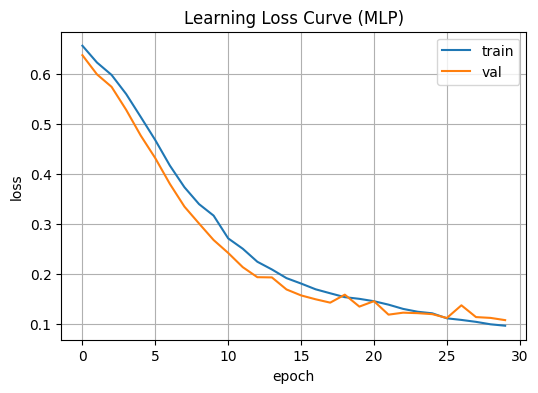

In [ ]:
# 損失が減少していく様子をグラフ表示する
%matplotlib inline
from matplotlib import pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Learning Loss Curve (MLP)') # タイトル
plt.plot(train_loss_list, label='train') # 訓練ロスグラフ
plt.plot(val_loss_list, label='val') # 検証ロスグラフ
plt.legend() # 凡例
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(axis="both") # グリッド表示

plt.show()

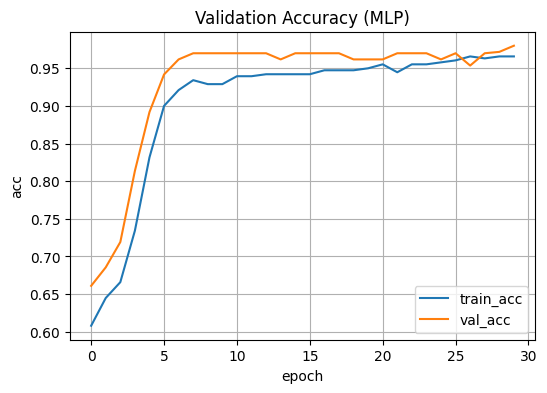

正解率：0.980


In [ ]:
# 正解率が上昇していく様子をグラフ表示する

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Validation Accuracy (MLP)') # タイトル
plt.plot(train_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend() # 凡例
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(axis="both") # グリッド表示

plt.show()
print(f'正解率：{val_acc_list[-1]:.3f}')
# print('正解率：',val_acc_list[-1]*100, '%')

## 訓練済みモデルを保存する


In [ ]:
# 現在の作業ディレクトリに訓練済みモデルのパラメータ値を保存する

torch.save(model.state_dict(), './cancer_mlp.pkl')

In [ ]:
# フォルダを確認する
!ls -F

breastcancer.xlsx  cancer_mlp.pkl  __pycache__/  train_valid.py


# 学習済みモデルを評価する

## テストデータでモデルの予測性能を評価する

In [ ]:
# テストを実施する

# テスト
test_loss, test_acc = valid(model, criterion, optimizer, test_loader, device)
print('test_loss: %.2f \ttest_acc: %.2f' % (test_loss, test_acc))


test_loss: 0.14 	test_acc: 0.95


# まとめ
フレームワーク（PyTorch）を利用して，全結合型ニューラルネットワークモデル（MLP: Multi-Layer Perseptron）を構築し，Cancerデータの分類を行った．
- 95%以上の高精度で，Cancerデータのがんの悪性と良性を予測できた
- ニューラルネットワークの**「学習」の一連の手続き**が理解できた
  1. データの準備
    1. データの前処理（スケール変換とテンソル変換）
    1. データセット（データとラベルの組）の作成
    1. データ分割（訓練用，検証用，テスト用）
    1. データローダの作成
  1. MLPモデルの定義
  1. モデルの訓練と検証
  1. モデルの評価と推論
- ニューラルネットワークの**「学習」の技術用語**が理解できた
  - エポック
  - ミニバッチ
- フレームワークPyTorchの使い方が理解できた
- MLPモデルの構造と定義方法が理解できた
- モデルの訓練と検証方法が理解できた
  - 訓練データで訓練，検証データで学習状況の確認
- モデルの性能評価方法が理解できた
  - テストデータ


# [提出課題]
1. 課題1
  1. MLPモデルの層を以下のように修正する
    ```
    # 提出課題1では以下のネットワーク設定を使用する（以下のコメントを外し，上をコメントにする）
    self.layer_1 = nn.Linear(30, 10)      # 入力：30，入力層出力：10
    self.layer_2 = nn.Linear(10, 5)      # 中間層入力：10，中間層出力：5
    self.layer_3 = nn.Linear(5, 2)       # 出力層入力：5，出力：2
    ```
  1. 以下の手順でプログラムを再実行する
    1. メニューバーの，ランタイム ／ ランタイムを再起動
    1. メニューバーの，ランタイム ／ すべてのセルを実行

  1. テストデータでモデルの予測性能を評価する
    1. test_loss の値を小数第二位までで答えよ
    1. test_acc の値を小数第二位までで答えよ


1. 課題2

  1. MLPモデルの層を以下のように修正する
    ```
    # 提出課題2では以下のネットワーク設定を使用する（以下のコメントを外し，上をコメントにする）
    self.layer_1 = nn.Linear(30, 60)      # 入力：30，入力層出力：60
    self.layer_2 = nn.Linear(60, 10)      # 中間層入力：60，中間層出力：10
    self.layer_3 = nn.Linear(10, 2)       # 出力層入力：10，出力：2
    ```
  1. 以下の手順でプログラムを再実行する
    1. メニューバーの，ランタイム ／ ランタイムを再起動
    1. メニューバーの，ランタイム ／ すべてのセルを実行

  1. テストデータでモデルの予測性能を評価する
    1. test_loss の値を小数第二位までで答えよ
    1. test_acc の値を小数第二位までで答えよ